# Body temperature assignment
## Yoav Ram

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import pandas as pd
import emcee
from corner import corner
import seaborn as sns
sns.set_context('notebook')
sns.set_palette('muted')

import zipfile
import urllib.request
import os

red, blue, green = sns.color_palette('Set1', 3)

In this analysis we will compare the body temperature of animals to check if indeed there is such a thing as [warm-blooded](http://en.wikipedia.org/wiki/Warm-blooded) and cold-blooded animals.

## Data loading and preprocessing

We start by loading the data.

In [4]:
data = pd.read_table('../data/anage_data.txt')

The temperatures are in Kelvin degrees in the `Temperature (K)` column, and we like Celsius degrees.
So we transform the temperature to Celsius and save the result in a new column.

Note: SciPy has a special function for Kelvin to Celsius conversion.

In [5]:
from scipy.constants import convert_temperature
data['Temperature (C)'] = convert_temperature(data['Temperature (K)'], 'K', 'C')

Next, we clean the data frame from rows with missing values in the temperature column.
We remove from the data classes with fewer than 10 species -- these are the birds.

In [6]:
data = data[np.isfinite(data['Temperature (C)'])]
data['Class'].value_counts()

Mammalia    457
Amphibia     18
Reptilia     16
Aves          3
Name: Class, dtype: int64

In [8]:
data = data[data["Class"] != 'Aves'] 

We are left with mammals, reptiles, and amphibians.

We collate together the non-mammals (reptiles and amphibians).

In [9]:
mammals = data['Class'] == 'Mammalia' 

**Plot a histogram of the temperature**: one histogram for mammals, and one histogram for amphibians and reptiles.

Plot the histograms on the same figure. Use `density=True` so that the histograms will be normalized, since there are many more mammals.

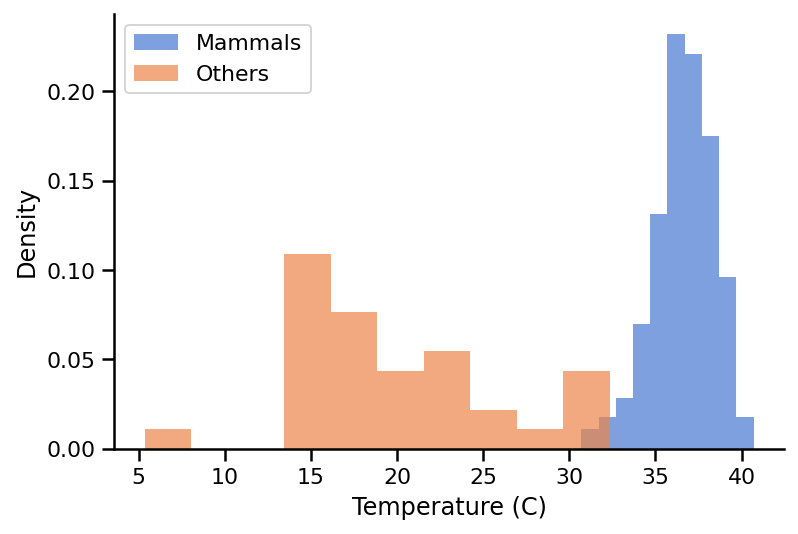

In [10]:
plt.hist(data.loc[mammals, 'Temperature (C)'], density=True, alpha=0.7, label='Mammals')
plt.hist(data.loc[~mammals, 'Temperature (C)'], density=True, alpha=0.7, label='Others')
plt.legend()
plt.xlabel('Temperature (C)')
plt.ylabel('Density')
sns.despine()

## Frequentist approach: t-test

OK. Now we want to compare these two empirical distribution: do they come from the same distribution? What is the probability that there is no difference between mammals and amphibians/reptiles, and that the difference we see in the dataset is a fluke?

The standard frequntist approach for this is [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test), which is used _"to determine if the means of two sets of data are significantly different from each other."_

This test assumes that the data are normally distributed around the mean (the histogram looks OK, I guess), but it also assumes that the variance is equal in the two distibutions, which doesn't seem to be the case.

A more robust test is [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test). 
The test statistic is defined as:
$$
t=\frac{\bar{X}_{1}-\bar{X}_{2}}{\sqrt{\frac{s_{1}^{2}}{N_{1}}+\frac{s_{2}^{2}}{N_{2}}}},
$$
where $X_i$ is dataset $i$, $\bar{X}_i$ is it's mean, $s_i$ it's standard deviation, and $N_i$ it's size.

The numerator is just the difference in means - we want to test if this is dignificantly different than zero.
The denominator scales the mean difference using an estimate of the standard errors of the means.

Welch's test assumes normality, but not equal variance.

**Compute $t$ and print it.**

In [12]:
X1 = data.loc[mammals, 'Temperature (C)'].values 
X2 = data.loc[~mammals, 'Temperature (C)'].values 

X1bar = X1.mean()
X2bar = X2.mean()
s1 = X1.std(ddof=1)
s2 = X2.std(ddof=1)
N1 = X1.size
N2 = X2.size

t = (X1bar - X2bar) / np.sqrt(s1 * s1 / N1 + s2 * s2 / N2)

print('t = {:.3f}'.format(t)) 

t = 16.454


Welch showed that that $t$ is approximately t-distributed:

$$
t \sim \mathbb{t}(\nu)
$$

where the parameter $\nu$ for the distribution of $t$ is
$$
\nu \approx \frac{\left(\frac{s_{1}^{2}}{N_{1}}+\frac{s_{2}^{2}}{N_{2}}\right)^{2}}{\frac{s_{1}^{4}}{N_{1}^{2} \nu_{1}}+\frac{s_{2}^{4}}{N_{2}^{2} \nu_{2}}}
$$
where $\nu_i = N_i-1$. We won't get into how this is all constructed -- this requires some mathematical abckground.

However, we will compute the probability to draw from $\mathbb{t}(\nu)$ a value as extreme as $t$.
We will print this probability, which is commonly called the _p-value_ of the test.

This p-value tells gives us what we were looking for: the probability that the two distributions actually have the same mean, despite the disparity we see.
As you will see, the p-value is extremely low, and therefore we can reject the hypothesis (which is usually called the null hypothesis) that there is no difference between the temperature of mammals and amphibians/reptiles.

_Note:_ we use `scipy.stats.t.sf(x) * 2` (`sf(x) = 1 - cdf(x)`), which returns the probability to get a value as extreme (very large or very small) as `x`. This "very small or very large" is considered a two-sided test: we want to if either mean is much greater than the other one.

In [14]:
ν = (s1 * s1 / N1 + s2 * s2 / N2)**2 / (s1**4 / (N1*N1*(N1-1)) + s2**4 / (N2 * N2 * (N2-1)))

pvalue = scipy.stats.t.sf(t, ν) * 2
print('p-value: {:.2g}'.format(pvalue)) 

p-value: 1.4e-17


By the way, we could have just used `scipy.stats.ttest`. Here's how to do that:

In [15]:
t, pvalue = scipy.stats.ttest_ind(X1, X2, equal_var=False)
print("P-value: {:.2g} (t={:.3f})".format(pvalue, t))

P-value: 1.4e-17 (t=16.454)


## Bayesian approach: BEST

Now let's do this using Bayesian statistics, with an approach called BEST ([Bayesian Estimation Supersedes the T-test](https://psycnet.apa.org/fulltext/2012-18082-001.pdf)).

The nice thing is that once we understand Bayesian inference, we can easily understand BEST; whereas with the t-test, we need to specifically understand t-distributions, which looks very complicated.

How are we modelling the data?
Similarly to the t-test, we assume normality:

$$
X_1 \sim N(\mu_1, \sigma_1^2) \\
X_2 \sim N(\mu_2, \sigma_2^2)
$$

So the model parameters are $\theta=(\mu_1, \mu_2, \sigma_1, \sigma_2)$.

**Start by infering $\theta$** using _emcee_ (or your own MCMC code if you prefer).

To have a full description of our model we need to specify the prior for $\theta$.
We provide wide priors for $\mu_i$ around the sample mean, and some exponential prior for the standard deviation terms: 

$$
\mu_i \sim N(\bar{X}, 1000), \\
\sigma_i \sim Exp(10)
$$

here $\bar{X}$ is the mean of all the samples (including all of $X_1$ and $X_2$), and $Exp(10)$ is an exponential distribution with mean 10 (implemented with `scipy.stats.expon(scale=10)`).

In [16]:
X = np.concatenate((X1, X2)) 
Xbar = X.mean() 

μ_prior = scipy.stats.norm(Xbar, 1000)
σ_prior = scipy.stats.expon(scale=10)

def log_prior(θ): 
    μ1, μ2, σ1, σ2 = θ
    return (μ_prior.logpdf(μ1) + 
            μ_prior.logpdf(μ2) + 
            σ_prior.logpdf(σ1) +
            σ_prior.logpdf(σ2)
    )
    
def log_likelihood(θ, X1, X2): 
    μ1, μ2, σ1, σ2 = θ
    return scipy.stats.norm.logpdf(X1, μ1, σ1).sum() + scipy.stats.norm.logpdf(X2, μ2, σ2).sum()
    
def log_posterior(θ, X1, X2): 
    pri = log_prior(θ) 
    if not np.isfinite(pri): 
        return pri
    return pri + log_likelihood(θ, X1, X2)

In [18]:
ndim = 4  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nsteps = 500  # number of MCMC steps to take
nburn = nsteps//2  # "burn-in" period to let chains stabilize

guesses = np.empty((nwalkers, ndim)) 
guesses[:, 0] = μ_prior.rvs(nwalkers)
guesses[:, 1] = μ_prior.rvs(nwalkers)
guesses[:, 2] = σ_prior.rvs(nwalkers)
guesses[:, 3] = σ_prior.rvs(nwalkers)

In [19]:
sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers, 
    ndim=ndim,
    log_prob_fn=log_posterior,
    args=[X1, X2]
)
sampler.run_mcmc(
    initial_state=guesses,
    nsteps=nsteps
);

# sampler.chain.shape = (nwalkers, nsteps, ndim)

After inferring the parameters, we plot a trace plot to make sure the Markov chain has converged.

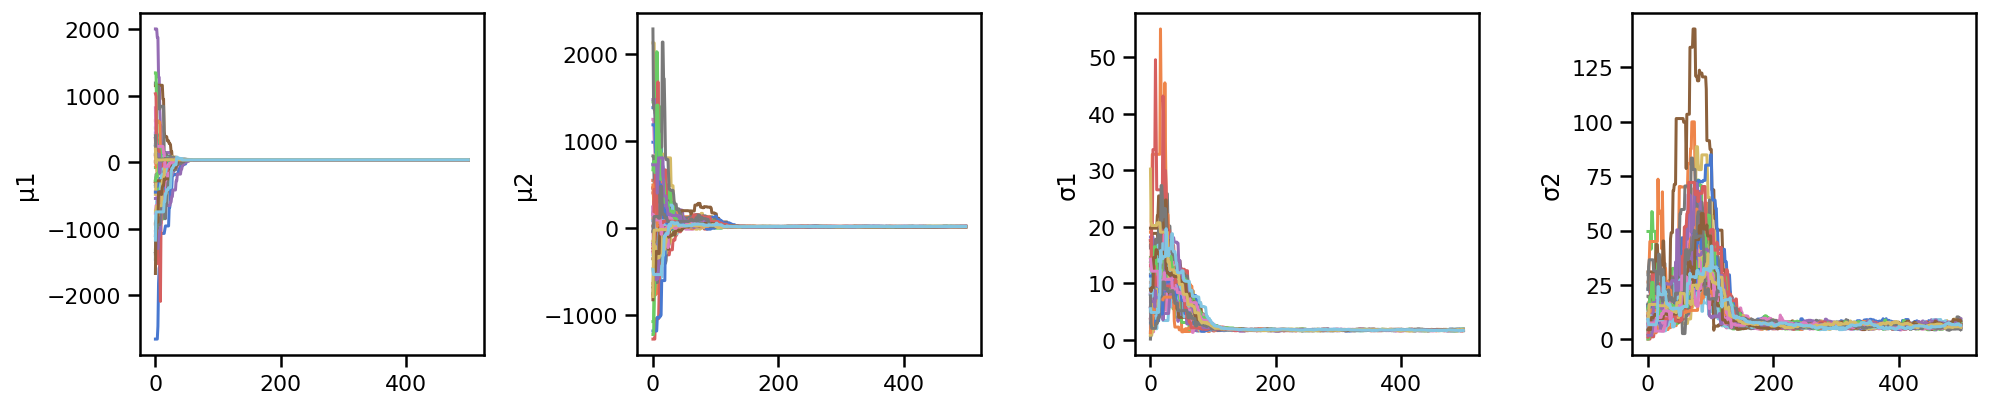

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3), sharex=True)

for i, label in enumerate(['μ1', 'μ2', 'σ1', 'σ2']):
    for j in range(nwalkers):
        axes[i].plot(sampler.chain[j, :, i])
        axes[i].set_ylabel(label)
fig.tight_layout()

**Take the samples after the burnin period** and reshape if required (for example if you used more then one chain/walker).

In [21]:
sample = sampler.chain[:, nburn:, :]
sample = sample.reshape((-1, ndim))

**Plot a corner plot** to examine the posterior. It should show nice gaussians, both on and off the diagonal.

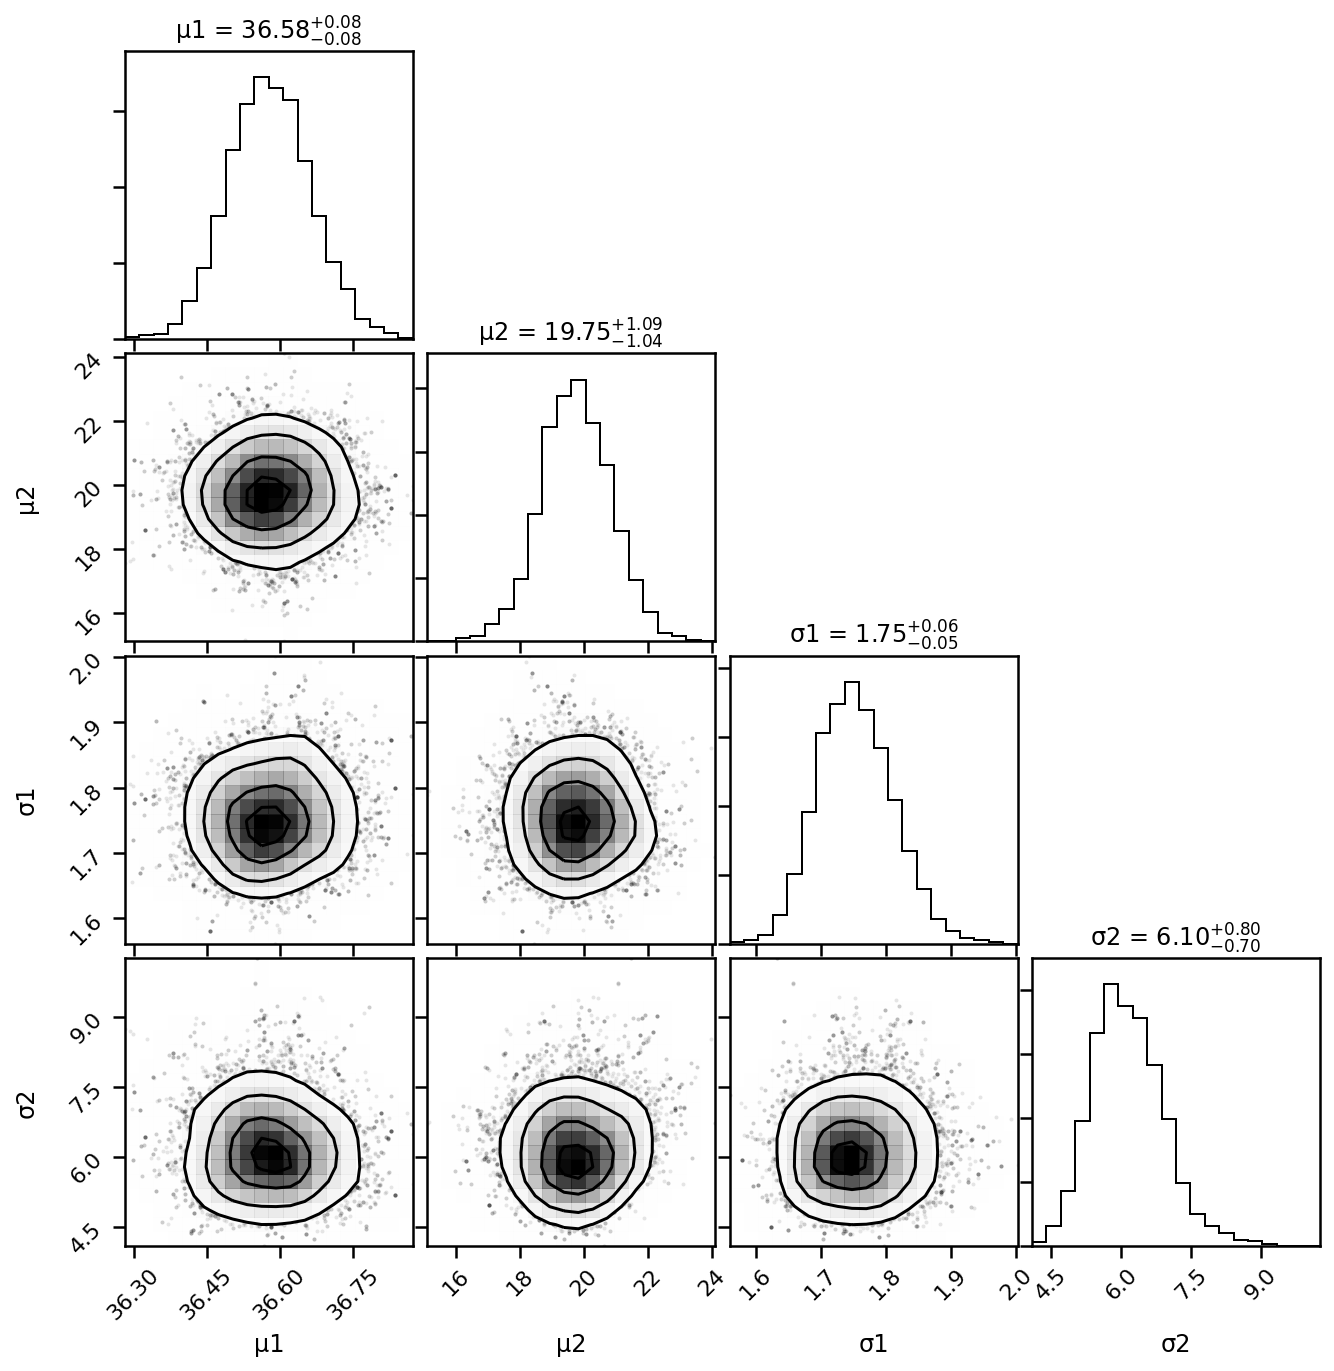

In [22]:
cor = corner(sample, 
    smooth=True,
    labels=['μ1', 'μ2', 'σ1', 'σ2'],
    show_titles=True,
)

Finally, we can do the Bayesian estimation for the difference between the means $\mu_1$ and $\mu_2$ by computing the posterior of the difference $\Delta\mu = \mu_1 - \mu_2$:
- **compute the difference** between the posterior samples of $\mu_1$ and $\mu_2$ to get posterior samples of $\Delta\mu$,
- **plot the histogram of the posterior** of $\Delta\mu$ (note how far the distribution is from zero!),
- **print the probability that $\mu_1>\mu_2$** according to the posterior of $\Delta\mu$.

P(μ1 > μ2) = 1.0


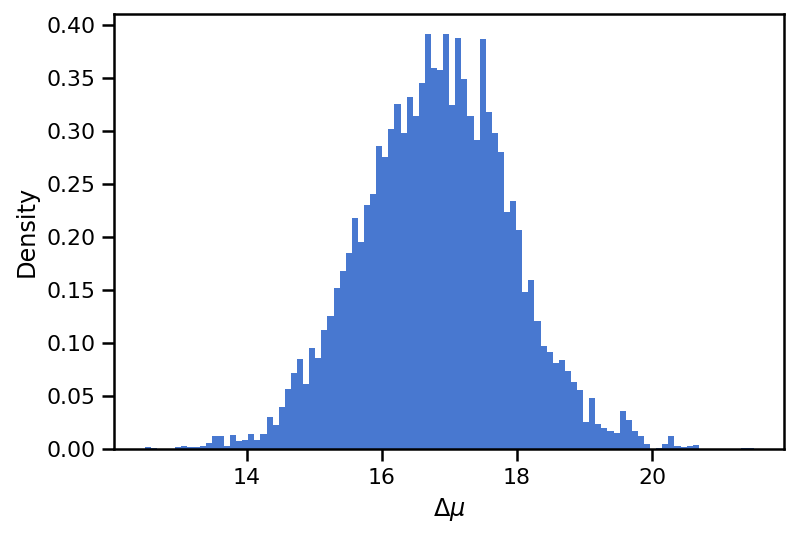

In [23]:
μ1_sample = sample[:, 0]
μ2_sample = sample[:, 1]
Δμ = μ1_sample - μ2_sample

plt.hist(Δμ, bins=100, density=True)
plt.xlabel(r'$\Delta\mu$')
plt.ylabel('Density')

print('P(μ1 > μ2) =', (Δμ > 0).mean())

We therefore infer that $P(\mu_1 > \mu_2) \approx 1$, that is, that the _mean temperature of mammals is larger than that of amphibians/reptiles with very high confidence_.